In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import pymc3 as pm
import pandas as pd

%matplotlib inline

In [102]:
dfCr = (pd.read_csv('./DataAzadbeh.csv'))
dfCr['mat_code'] = dfCr['material'].map({'ACrL': 0 , 'ACrM':1})
dfCr['Er']=dfCr.E_Gpa/212

In [96]:
1-2.9/7.86

0.6310432569974556

In [61]:
# Test data
Xtrain=df.P # Relative porosity
Ytrain=df.Er #Relative E
n=len(Xtrain)

In [62]:
Xdata = np.column_stack((Xtrain, Xtrain**2)) #Regressors matrix
df.mat_code.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [63]:
coords = {"material": ["ACrL","ACrM"], "obs_id": np.arange(df.mat_code.size)}
with pm.Model(coords=coords) as model:
    
    mat_idx = pm.Data("mat_idx", df.mat_code.values, dims="obs_id")
    #E0_mu =pm.Normal('E0_mu', mu=210, sd=10)
    #E0=pm.Normal('E0', mu=E0_mu, sd=10, dims="material")
    mu_b = pm.Normal('mu_b',1.95, 0.5)
    ke = pm.Normal('ke', mu=mu_b, sd=0.5, dims="material")
    
    ke_mat=ke[mat_idx]
    
    
    # regression data
    beta = [-ke_mat-1, ke_mat]
    
    Xshared=pm.Data('porosity', Xdata)

        #link function
    mu =  (1 + pm.math.dot(Xshared, beta))
    sigma = pm.HalfCauchy('sigma', beta=1)

    #likelihood
    
    y = pm.Normal('y', mu =mu, sd= sigma, observed = Ytrain, dims='obs_id')
    
    trace=pm.sample(5000, random_seed=1235)

<ipython-input-63-045008683397>:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(5000, random_seed=1235)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ke, mu_b]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1615 seconds.


0, dim: obs_id, 30 =? 30


In [77]:
1-2.9/7.86

0.6310432569974556

In [64]:
#Posterior predictive
Xtest =np.linspace(0,0.5,50)

with model:
    #pm.set_data({'porosity': np.column_stack((Xtest, Xtest**2)) })
    y_test = pm.sample_posterior_predictive(trace)

In [67]:
import arviz as az

with model:   
    idata = az.from_pymc3(trace, posterior_predictive = y_test)

0, dim: obs_id, 30 =? 30


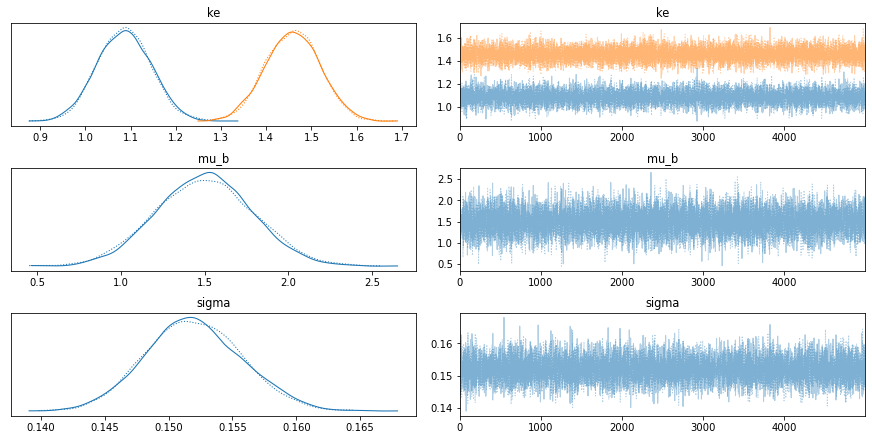

In [68]:
az.plot_trace(idata, var_names=['ke','mu_b', 'sigma']);

In [70]:
az.summary(idata, var_names=['ke','mu_b', 'sigma'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ke[0],1.085,0.059,0.972,1.201,0.000,0.000,16646.0,8252.0,1.0
ke[1],1.459,0.060,1.342,1.575,0.000,0.000,17606.0,8155.0,1.0
mu_b,1.499,0.289,0.957,2.089,0.002,0.002,16512.0,8201.0,1.0
sigma,0.152,0.004,0.145,0.159,0.000,0.000,17507.0,7590.0,1.0


In [80]:
1/1.499

0.66711140760507

In [79]:
1-2.95/7.86

0.6246819338422391

abc

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\data\base.py:169: UserWarning: More chains (10000) than draws (30). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


<AxesSubplot:>

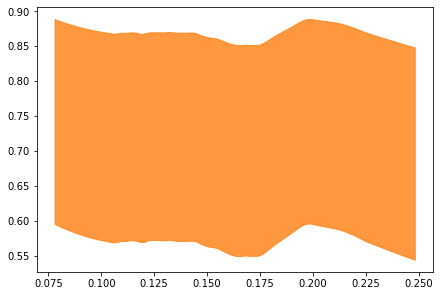

In [71]:
az.plot_hdi(Xtrain, (y_test['y']), hdi_prob=0.6, fill_kwargs={"alpha": 0.8})

In [36]:
(y_test['y'].mean(axis=0)).mean(axis=1).shape

(30,)

In [37]:
pooled_means = idata.posterior.mean(dim=("chain", "draw"))
pooled_means

<xarray.Dataset>
Dimensions:   (material: 2, mu_dim_0: 30, mu_dim_1: 30)
Coordinates:
  * material  (material) <U4 'ACrL' 'ACrM'
  * mu_dim_0  (mu_dim_0) int32 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * mu_dim_1  (mu_dim_1) int32 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
Data variables:
    ke        (material) float64 1.076 1.454
    sdke      float64 1.469
    mu        (mu_dim_0, mu_dim_1) float64 0.5896 0.5896 ... 0.7986 0.7986
    sigma     float64 0.152

In [ ]:
1.459	0.060	1.342	1.575	575

In [81]:
yd =y_test['y'].mean(axis=0)
yd1=np.percentile(yd,97.5,axis=1)
yd2=np.percentile(yd,2.5,axis=1)

In [90]:
import seaborn as sns

In [109]:
y_mean_ =(1-1/0.63*Xtest)*(1-Xtest)

<AxesSubplot:xlabel='P', ylabel='Er'>

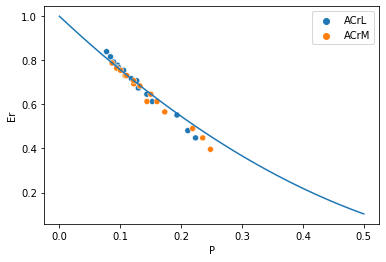

In [110]:
sns.scatterplot(x=dfCr['P'], y=dfCr['Er'], hue=dfCr['material'])
sns.lineplot(x=Xtest, y=y_mean_)

<AxesSubplot:xlabel='Relative porosity', ylabel='Relative E modulus (Er)'>

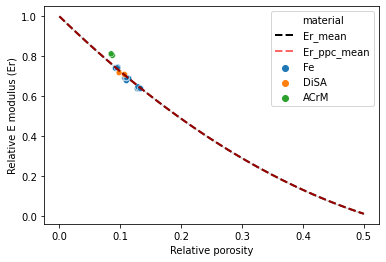

In [162]:
plt.plot(Xtest, Ytest_mean, 'k--', lw=2, label='Er_mean')
plt.gca().fill_between(Xtest.flat, yd2 , yd1, color ='#dddddd', alpha=1)
#plt.scatter(Xtrain_p,Ytrain, label='Er_data')
plt.plot(Xtest, yd.mean(axis=1), 'r--',lw=2, label="Er_ppc_mean", alpha=0.6)
plt.legend()
plt.xlabel('Relative porosity')
plt.ylabel('Relative E modulus (Er)')
sns.scatterplot(x=df['porosity'], y=df['Er'], hue=df['material'])
#plt.xlim([0, 0.2])
#plt.ylim([0.5,1])